In [1]:
from fastai.conv_learner import *
from fastai.dataset import *
import xmltodict
import ast
import random

from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
PATH = Path("../data/hanged_man")
MASTERCSV = PATH/"tmp/data_master.csv"
CLASSESCSV = PATH/"tmp/classes.csv"
MBB_CSV = PATH/'tmp/mbb.csv'
JPEGS = 'f_train'

converters = {"annos":ast.literal_eval,"class_id":ast.literal_eval, "class_str":ast.literal_eval}

In [4]:
# dir_anno = sorted((PATH/"annotations").iterdir())
# train_apaths = {i:fn for i,fn in enumerate(dir_anno)}
# train_fnid = {fn.name[:-4]:i for i,fn in  enumerate(dir_anno)}
# train_t_fnid = {i:fn.name[:-4] for i,fn in  enumerate(dir_anno)}
# train_fpaths = {i: (PATH/f"f_train/{fn}.png") for i,fn in train_t_fnid.items()}

In [4]:
def switch_xy(bb): return [bb[1],bb[0],bb[3],bb[2]]

def crawl_anno():
    df = pd.DataFrame([])
    classes = {}
    t_classes = {}
    for file in sorted((PATH/"annotations").iterdir()):
        with open(file,"r") as f:
            data = xmltodict.parse(f.read(), force_list={'object'})
        annos=[]
        clsses=[]
        clsses_id=[]
        bb_str=""
        for ob in data['annotation']['object']:
            try:
                if ob['name'] not in classes.values():
                    classes.update({len(classes): ob['name']})
                    t_classes.update({ob['name']:len(t_classes)})
                clsses.append(ob['name'])
                clsses_id.append(t_classes[ob['name']])
                
                bb = [int(ob['bndbox'][x]) for x in ob['bndbox']]
                bb = switch_xy(bb)
                bb_str += ' '.join(str(b) for b in bb) + ' '
                annos.append([bb,t_classes[ob['name']]])
                
            except Exception as e:
                print(data['annotation']['filename'], ob)
                return data
#                 continue
        if len(annos):
            df = df.append({'fn':f'{file.name[:-4]}.png','annos':annos,'class_str': clsses, 'class_id': clsses_id, 'bb_str': bb_str.strip()},ignore_index=True)
    
    df.reset_index(inplace=True)
    df.columns = ['id','annos','bb_str','class_id','class_str','fn']
    df.to_csv(MASTERCSV,index=False)
    
    dclasses = pd.DataFrame.from_dict(classes,orient="index").reset_index()
    dclasses.columns = ['id','class']
    dclasses.to_csv(CLASSESCSV,index=False)
    return df, classes, t_classes

# data, classes, t_classes = crawl_anno()

In [4]:
data = pd.read_csv(MASTERCSV, converters = converters)
classes = pd.read_csv(CLASSESCSV)

In [7]:
# fn = frame_1.png
# data.query("fn==@fn")
# PATH/f'f_train/{data.query("id==@i").fn.values[0]}'

In [5]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [6]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], classes.query("id==@c"), sz=16)

def draw_idx(i):
    im_a = data.query('id==@i')
    im = open_image(PATH/f'f_train/{data.query("id==@i").fn.values[0]}')
    draw_im(im, im_a)

In [5]:
mc = data.class_str.tolist()
t_mc = np.array(data.class_id.apply(lambda x: np.array(x)))

In [6]:
val_idxs = get_cv_idxs(len(data))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, t_mc)

In [9]:
mbbs = data.loc[:,"bb_str"].tolist()

data_mbb = data.loc[:,['fn','bb_str']].copy()
data_mbb.columns = ['fn','bbox']
data_mbb.to_csv(MBB_CSV,index=False)

In [7]:
base_model = resnet34
sz=224
bs=8

aug_tfms = [RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
           RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(base_model, sz, aug_tfms=aug_tfms, crop_type=CropType.CENTER, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)
md2 = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms)

In [17]:
md.trn_dl.get_batch([2,1])[0].shape

(2, 3, 224, 224)

In [11]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds = ds
        self.y2 = y2
        self.sz = ds.sz
        
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y, self.y2[i]))

In [12]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
# trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
# val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [13]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 6
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [34]:
def show_gt(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(b) for b in bbox.reshape(-1,4)]
    if clas is None: clas = [None]*len(bb)
    if prs is None: prs = [None]*len(bb)
    ax = show_img(im,ax=ax)
    for i, (b,cls,pr) in enumerate(zip(bb,clas,prs)):
        if ((b[2]>0)) and (pr is None or pr > thresh):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if cls is not None: txt = (' ' if cls==len(classes) else classes.loc[classes.id==cls,'class'].values[0])
            if pr is not None: txt += f" {pr:.2f}"
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [15]:
x, y = to_np(next(iter(md.val_dl)))
x = md.val_ds.ds.denorm(x)

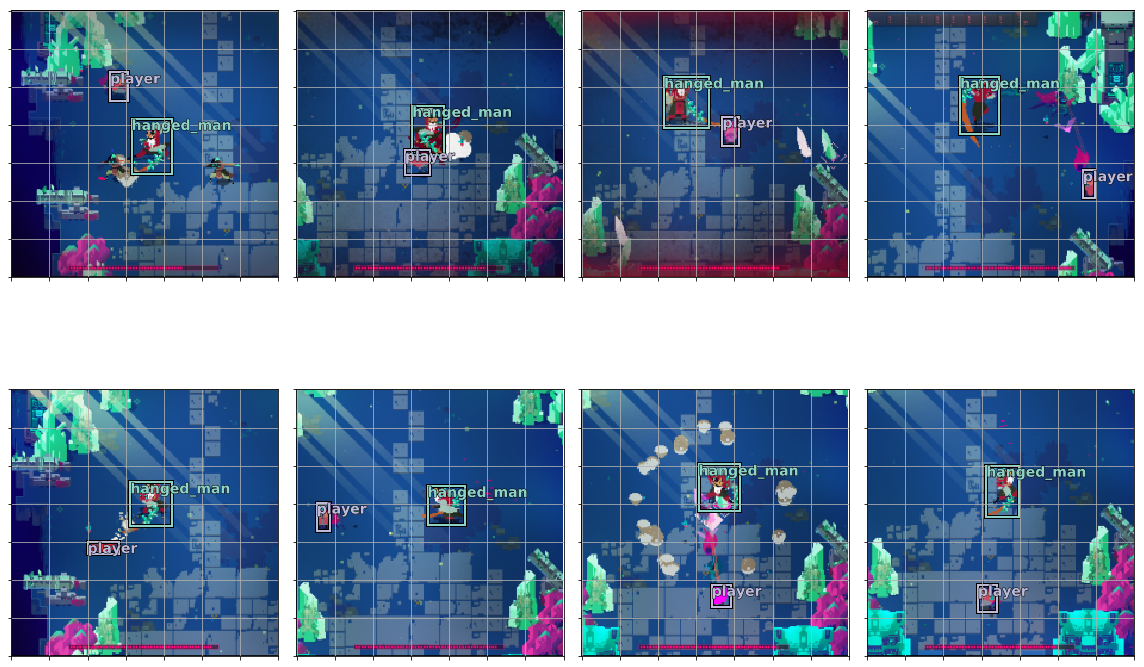

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(16, 12))
for i, ax in enumerate(axes.flat):
    show_gt(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

In [17]:
anc_grid = 7
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range (anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
n_clas = len(classes)+1
n_act = k*(4+n_clas)

In [106]:
# def conv_calc(w,q,p,s):
#     y = (w-q+2*p)/s+1
#     print(y)
#     return y
    
# q = conv_calc(512,3,1,1)
# q = conv_calc(q,3,1,1)
# q = conv_calc(q,2,0,2)
# # q = conv_calc(q,3,1,2)

512.0
512.0
256.0


In [18]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.long().cpu(),]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())
        x = pred[:,:-1]
        w = self.get_weight(x, t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self, x, t): return None

loss_f = BCE_Loss(len(classes))

In [19]:
def intersect(box_a, box_b):
    """ Returns the intersection of two boxes """
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): 
    """ Returns the box size"""
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    """ Returns the jaccard distance between two boxes"""
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def get_y(bbox,clas):
    """ ??? """
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    """ activations to bounding boxes """
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    """ ?? """
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox, clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.3
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(classes)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [20]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
#     def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
    def forward(self, x): return self.drop((F.relu(self.conv(x))))


def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv0 = StdConv(256,256,stride=1)
        self.oconv1 = nn.Conv2d(nin, n_clas*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(self.oconv0(x)), self.k),
                flatten_conv(self.oconv2(x), self.k)]
    
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv1 = StdConv(256,256, stride=1)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        return self.out(self.sconv1(self.sconv0(self.drop(F.relu(x)))))

In [21]:
head_reg4 = SSD_Head(k, -2.)
models = ConvnetBuilder(base_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

x, y = next(iter(md.trn_dl))
x, y = V(x), V(y)

learn.model.cuda()
batch = learn.model(x)
# ssd_loss(batch, y, True)

In [77]:
ssd_loss(batch, y, True)


 0.3515
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3417
 0.1751
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.0970
 0.3181
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.0781
 0.1826
 0.2822
 0.1074
[torch.cuda.FloatTensor of size 4 (GPU 0)]


 0.1233
 0.4453
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.1484
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.0658
 0.1758
 0.4477
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.0985
 0.3162
[torch.cuda.FloatTensor of size 2 (GPU 0)]

loc: 0.40890079736709595, clas: 281.5806579589844


Variable containing:
 281.9896
[torch.cuda.FloatTensor of size 1 (GPU 0)]

 59%|█████▊    | 75/128 [00:05<00:04, 12.63it/s, loss=116] 


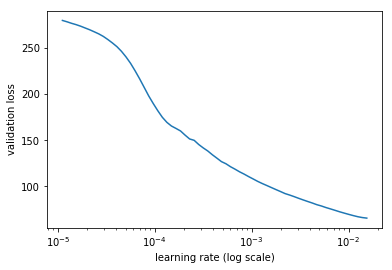

In [78]:
learn.crit = ssd_loss
lr = 2e-3
lrs = np.array([lr/100,lr/10,lr])
learn.lr_find()
learn.sched.plot(1)

In [ ]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20,10))

 76%|███████▌  | 97/128 [00:15<00:05,  6.19it/s, loss=45.9]

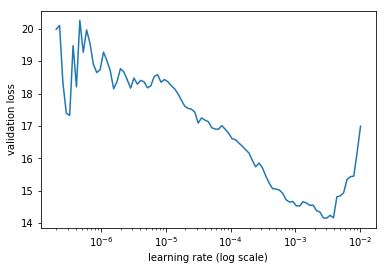

In [81]:
learn.freeze_to(-35)
learn.lr_find(lr/10000,1.)
learn.sched.plot(0)

In [82]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

 30%|███       | 39/128 [00:06<00:13,  6.42it/s, loss=13.3]

KeyboardInterrupt: 

In [96]:
learn.save('NBN-7')

In [32]:
learn.load('FL-77')

In [27]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_gt(ax, ima,
                             to_np((bbox*sz).long()),
                             to_np(clas),
                             to_np(prs) if prs is not None else None,
                             thresh)

In [28]:
head_reg4 = SSD_Head(k, +2.)
models = ConvnetBuilder(base_model, 0, 0, 0, custom_head=head_reg4,)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [29]:
learn.load('NBN-7')

In [30]:
q =iter(md.val_dl)

In [31]:
x,y = next(q)
x,y = V(x), V(y)
learn.model.eval()
batch = learn.model(x)
b_clas, b_bb = batch

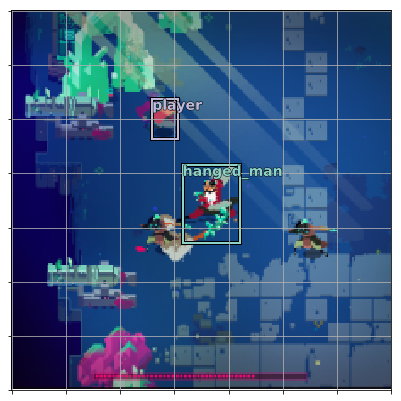

In [32]:
idx= random.choice(range(len(b_clas)))
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

In [35]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1], thresh=.9)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f750b00f950> (for post_execute):


ValueError: 'vertices' must be a 2D list or array with shape Nx2

ValueError: 'vertices' must be a 2D list or array with shape Nx2

<Figure size 504x504 with 1 Axes>

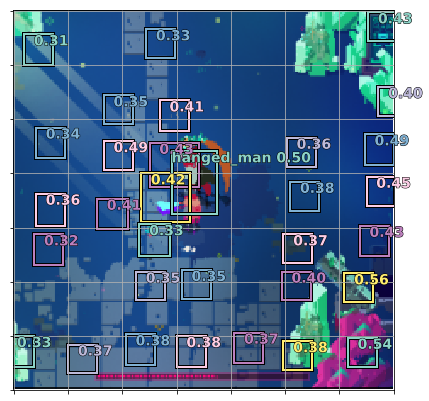

In [34]:
a_ic = actn_to_bb(b_bboxi, anchors)
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.3)

In [ ]:
# m = 4
# fig, axes = plt.subplots(2, m, figsize=(16, 12))
# models = ["FL-77", "NBN-7"]
# batches = []
# ims = []
# for i,mod in enumerate(models):
#     learn.load(mod)
#     learn.model.eval()
#     batches.append(learn.model(x[:m]))
#     ims.append(md.val_ds.ds.denorm(to_np(x))[:m])
# b_ims = [i for im in ims for i in im]
# b_cls = [prd.max(1)[1] for mo in batches for prd in mo[0]]
# b_bbs = [prd for mo in batches for prd in mo[1]]
# for i, ax in enumerate(axes.flat):
#     torch_gt(ax, b_ims[i], anchor_cnr, b_cls[i])

In [83]:
alpha, gamma = .25, 1.

In [89]:
class FocalLoss(BCE_Loss):
    def get_weight(self, x, t):
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha) * (1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(classes))

head_reg4 = SSD_Head(k, +2.)
models = ConvnetBuilder(base_model, 0, 0, 0, custom_head=head_reg4,)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

 80%|███████▉  | 102/128 [00:08<00:02, 12.07it/s, loss=82.6]

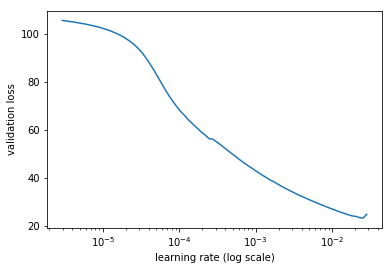

In [85]:
learn.crit = ssd_loss
lr = 1e-3
lrs = np.array([lr/100,lr/10,lr])
learn.lr_find(lrs/1000,1.)
learn.sched.plot()

In [86]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20,10))

epoch      trn_loss   val_loss                              
    0      5.475287   3.211366  
    1      2.992808   2.948686                              
    2      2.623822   2.462009                              
    3      2.475122   2.290135                              
    4      2.333728   2.333494                              
    5      2.171013   2.215112                              
    6      2.077195   2.346036                              
    7      1.98026    2.159216                              
    8      1.860602   2.139491                              
    9      1.799661   2.062129                              
    10     1.694792   2.066167                              
    11     1.591713   2.018475                              
    12     1.50798    2.049223                              
    13     1.501245   2.032762                              
    14     1.381438   2.004936                              


[array([2.00494])]

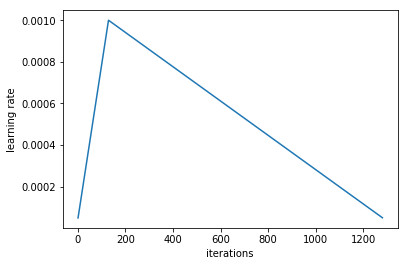

In [304]:
learn.sched.plot_lr()

epoch      trn_loss   val_loss                               
    0      0.559371   0.992641  


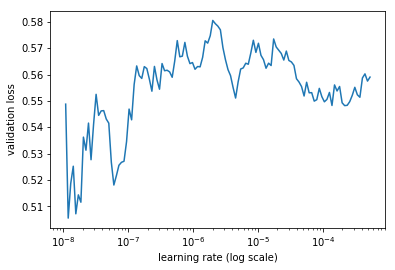

In [521]:
learn.freeze_to(-1)
learn.lr_find(lrs/10000, lr)
learn.sched.plot(1)

In [334]:
learn.load('FL-75')

In [97]:
learn.freeze_to(-35)
learn.fit(lr/10, 1, cycle_len=5, use_clr=(20,10))

epoch      trn_loss   val_loss                              
    0      1.93849    1.687545  
    1      1.292974   1.385262                              
    2      1.005056   1.331057                               
    3      0.826309   1.305241                               
    4      0.684464   1.292974                               


[array([1.29297])]

epoch      trn_loss   val_loss                               
    0      0.335225   1016.484173


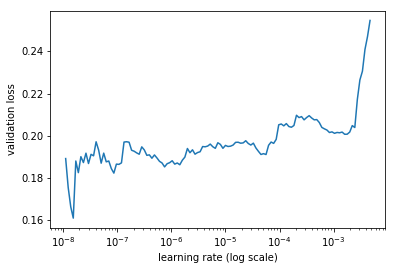

In [117]:
learn.freeze_to(-40)
learn.lr_find(lrs/100000, 1e-2)
learn.sched.plot(1)

In [332]:
learn.save('FL-77')

In [22]:
learn.load('FL-77')

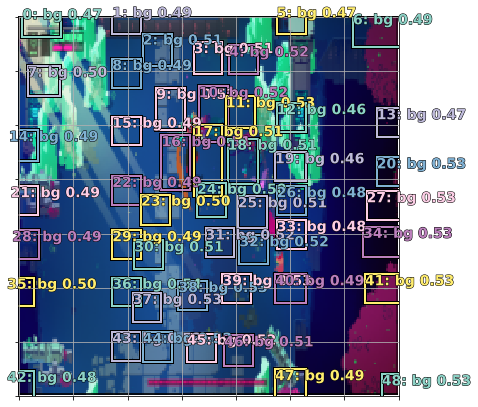

In [46]:
a_ic = actn_to_bb(b_bboxi, anchors)
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid())

In [57]:
b_clasi.max(1)[1]

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generated/../THCTensorMathReduce.cuh:692

In [58]:
# anc_grids = [4,2,1]
anc_grids = [7,10]
# anc_zooms = [0.7, 1., 1.3]
anc_zooms = [1.]
# anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids];k

1

In [54]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [55]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [56]:
a=np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

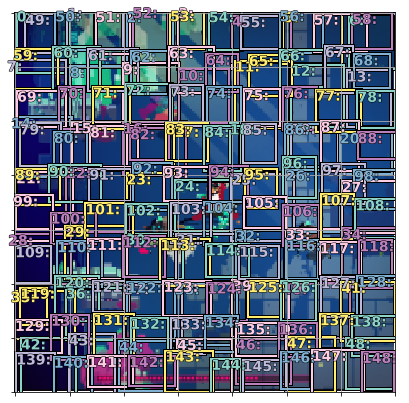

In [57]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)
fig, ax = plt.subplots(figsize=(7,7))
show_gt(ax, x[0], a)